# Multiple regressie

Tot nu toe hebben we gewerkt met een simpel lineair regressiemodel met maar één _predictor_ of _feature_ $\pmb{x}$ om de target waarden $\pmb{y}$ te voorspellen.
In het algemene geval $\pmb{y}=\pmb{X}\pmb{b}+\pmb{e}$, kunnen we de voorspellingen echter koppelen aan meerdere features in de _design- of feature-matrix_ $\pmb{X}$. Hier illustreren we de _OLS_ en _gradient descent_ oplossing in het geval waarbij we drie features hebben.
  
## Data simulatie
We blijven bij dezelfde simulatie van de fooi die klanten bovenop een bestelling in een koffiehuis betalen zodat we exact weten wat de optimale parameterwaarden zijn waar we naar op zoek zijn. We simuleren nu een situatie waarbij de fooi tot stand komt door een lineaire combinatie van ($\pmb{x_2}$) het order volume (in dollars), ($\pmb{x_3}$) de leeftijd van de klant (in jaren) en ($\pmb{x_4}$) de hoeveelheid regen (millimeter/dag):

$$
\begin{align}
\pmb{y} &= b_1 + b_2\pmb{x_2} + b_3\pmb{x_3} + b_4\pmb{x_4} + \pmb{e} \cr
E(\pmb{e}) &= \pmb{e} \cr
E(\pmb{y}) &= \pmb{X}\pmb{b} \cr
\pmb{X} &= \begin{bmatrix}
1 & x_{1,2} & x_{1,3} & x_{1,4} \cr
1 & x_{2,2} & x_{2,3} & x_{2,4}\cr
\vdots & \vdots \cr
1 & x_{m,2} & x_{m,3} & x_{m,4} \cr
\end{bmatrix} \cr
\pmb{b} &= \begin{bmatrix}
b_1 \cr
b_2 \cr
b_3 \cr
b_4
\end{bmatrix}
\end{align}
$$

waarbij we het _intercept_ of de _bias_ termen $x_{i,1} = 1$ weglaten in de notatie.
  
Voor de simulatie gebruiken we concreet:

$$
\begin{align}
b_1 &= 0.50 \cr
b_2 &= 0.15 \cr
b_3 &= 0.05 \cr
b_4 &= -0.003 \cr
\cr
e_i &\sim N(0, 0.30) \cr
\cr
x_{i,2} &\sim U(3, 25) \cr
x_{i,3} &\sim U(20, 70) \cr
x_{i,4} &\sim U(0, 200)
\end{align}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Set style for prettier plots
plt.style.use("seaborn-v0_8")

rng = np.random.default_rng(42)  # Create a random number generator

# Simulate realistic coffee shop data
n_customers = 50

# True relationship:
b1 = 0.50
b2 = 0.15
b3 = 0.05
b4 = -0.003
noise_std = 0.30

# Generate feature values
order_totals = rng.uniform(3, 25, n_customers)
age = rng.uniform(0, 70, n_customers)
rain = rng.uniform(0, 200, n_customers)

# Generate corresponding tip amounts with realistic noise
true_tips = b1 + b2 * order_totals + b3 * age + b4 * rain
tip_noise = rng.normal(0, noise_std, n_customers)
observed_tips = true_tips + tip_noise
observed_tips = np.maximum(0, observed_tips)  # Tips can't be negative

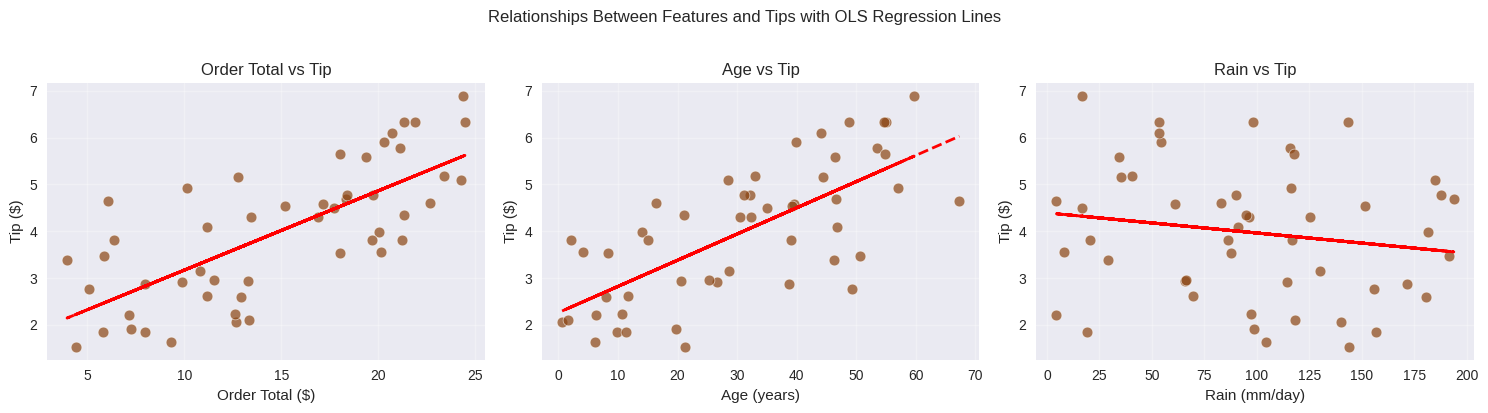

In [3]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Order Total vs Tip
axes[0].scatter(
    order_totals,
    observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
)
# Add OLS trendline
z1 = np.polyfit(order_totals, observed_tips, 1)
p1 = np.poly1d(z1)
axes[0].plot(order_totals, p1(order_totals), "r--", linewidth=2)
axes[0].set_xlabel("Order Total ($)")
axes[0].set_ylabel("Tip ($)")
axes[0].set_title("Order Total vs Tip")
axes[0].grid(True, alpha=0.3)

# Plot 2: Age vs Tip
axes[1].scatter(
    age,
    observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
)
# Add OLS trendline
z2 = np.polyfit(age, observed_tips, 1)
p2 = np.poly1d(z2)
axes[1].plot(age, p2(age), "r--", linewidth=2)
axes[1].set_xlabel("Age (years)")
axes[1].set_ylabel("Tip ($)")
axes[1].set_title("Age vs Tip")
axes[1].grid(True, alpha=0.3)

# Plot 3: Rain vs Tip
axes[2].scatter(
    rain,
    observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
)
# Add OLS trendline
z3 = np.polyfit(rain, observed_tips, 1)
p3 = np.poly1d(z3)
axes[2].plot(rain, p3(rain), "r--", linewidth=2)
axes[2].set_xlabel("Rain (mm/day)")
axes[2].set_ylabel("Tip ($)")
axes[2].set_title("Rain vs Tip")
axes[2].grid(True, alpha=0.3)

plt.suptitle("Relationships Between Features and Tips with OLS Regression Lines", y=1.02)
plt.tight_layout()
plt.show()

## OLS

We werken altijd best met gestandaardiseerde waarden. Voor de feature matrix kunnen we handig gebruikmaken van scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

In [4]:
# Standardizing
# Targets
y_mean = np.mean(observed_tips)
y_std = np.std(observed_tips)
y_scaled = (observed_tips - y_mean) / y_std

# Features
X = np.column_stack((np.ones(n_customers), order_totals, age, rain))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:, 0] = 1.0  # reset the intercept column to all ones

# True parameter values
b1_scaled = (np.dot(np.array([b1, b2, b3, b4]), scaler.mean_) - y_mean) / y_std
b2_scaled, b3_scaled, b4_scaled = np.array([b2, b3, b4]) * scaler.scale_[1:] / y_std

We kunnen bevestigen dat we met een laag conditienummer te maken hebben, wat te verwachten is aangezien de features onafhankelijk van elkaar zijn gegenereerd.

In [5]:
# Confirm that there is no multicollinearity
condition_number = np.linalg.cond(X_scaled)
print(f"Condition number: {condition_number:.6f}")

Condition number: 1.133724


Toepassing van de _normal equations_:

In [6]:
XtX = X_scaled.T @ X_scaled
Xty = X_scaled.T @ y_scaled
beta = np.linalg.inv(XtX) @ Xty

print("Closed-form OLS coefficients:")
print(f"  β1 (bias): \t\t{beta[0]:.6f}\ttrue value: {b1_scaled:.6f}")
print(f"  β2 (Order Total): \t{beta[1]:.6f}\ttrue value: {b2_scaled:.6f}")
print(f"  β3 (Age): \t\t{beta[2]:.6f}\ttrue value: {b3_scaled:.6f}")
print(f"  β4 (Rain): \t\t{beta[3]:.6f}\ttrue value: {b4_scaled:.6f}")

Closed-form OLS coefficients:
  β1 (bias): 		0.000000	true value: -0.012221
  β2 (Order Total): 	0.666591	true value: 0.646223
  β3 (Age): 		0.636319	true value: 0.635362
  β4 (Rain): 		-0.114367	true value: -0.115728


We kunnen zien dat de OLS oplossing zonder veel extra moeite opgeschaald kan worden naar meerdere features. Wel is het zo dat in de praktijk de kans op multicollineariteit en dus ongedefinieerde inverses $(\pmb{X}^T\pmb{X})^{-1}$ stijgt, naarmate we meer features opnemen in ons model.

## Gradient descent

De algemene regel voor het stapsgewijze updaten van parameterschattingen blijft ook hier:

$$
\pmb{b}^{k+1} = \pmb{b}^k - \lambda \nabla \mathcal{L}(\pmb{b}^k)
$$

Nog steeds gebruikmakend van de _SSE loss_, moeten we nu op zoek naar de gradiënt:

$$
\nabla{\mathcal{L}_{SSE}} = \begin{bmatrix}
\frac{\partial \mathcal{L}_{SSE}}{\partial {b_1}^k} \cr
\frac{\partial \mathcal{L}_{SSE}}{\partial {b_2}^k} \cr
\frac{\partial \mathcal{L}_{SSE}}{\partial {b_3}^k} \cr
\frac{\partial \mathcal{L}_{SSE}}{\partial {b_4}^k}
\end{bmatrix}
$$

In de sectie over de _SSE gradient_ zagen we dat in het algemene geval van $N$ features, de gradiënt volgende vorm heeft:

$$
\nabla{\mathcal{L}_{SSE}} = \begin{bmatrix}
-2\sum_{i=1}^M(y_i - \sum_{j=1}^Nx_{ij}b_j)(x_{i,1}) \cr
-2\sum_{i=1}^M(y_i - \sum_{j=1}^Nx_{ij}b_j)(x_{i,2}) \cr
\vdots \cr
-2\sum_{i=1}^M(y_i - \sum_{j=1}^Nx_{ij}b_j)(x_{i,n})
\end{bmatrix}
$$

In matrix notatie kunnen we dit efficiënt reduceren tot:

$$
\nabla{\mathcal{L}_{SSE}} = -2\pmb{X}^T(\pmb{y} - \pmb{\hat{y}})
$$

Dit kunnen we als volgt implementeren.

In [7]:
def sse_gradient(X, y, b):
    """Compute the gradient of the SSE loss with respect to parameters b."""
    y_pred = X @ b
    residuals = y - y_pred
    gradient = -2 * X.T @ residuals
    return gradient


def loss_fn(X, y, b):
    """Compute the loss (SSE) given the input features, target values, and model parameters."""
    y_pred = X @ b
    residuals = y - y_pred
    return np.sum(residuals**2)

Voor gradient descent beginnen we steeds met een _educated guess_ voor de parameters:

In [8]:
# Initial coefficients
b = np.array([1.0, 1.0, 1.0, 1.0])

# Initial loss
loss_history = [loss_fn(X_scaled, y_scaled, b)]

# Learning rate
lr = 1e-5

# Number of iterations
n_iter = 10000

for i in range(n_iter):
    grad = sse_gradient(X_scaled, y_scaled, b)
    b -= lr * grad
    loss = loss_fn(X_scaled, y_scaled, b)
    loss_history.append(loss)
    if i % 1000 == 0 or i == n_iter - 1:
        print(f"Iteration {i + 1:4d}: loss = {loss:.6f}")

print("\nGradient descent coefficients:")
print(f"  β1 (bias): \t\t{b[0]:.6f}\tols value: {beta[0]:.6f}\ttrue value: {b1_scaled:.6f}")
print(f"  β2 (Order Total): \t{b[1]:.6f}\tols value: {beta[1]:.6f}\ttrue value: {b2_scaled:.6f}")
print(f"  β3 (Age): \t\t{b[2]:.6f}\tols value: {beta[2]:.6f}\ttrue value: {b3_scaled:.6f}")
print(f"  β4 (Rain): \t\t{b[3]:.6f}\tols value: {beta[3]:.6f}\ttrue value: {b4_scaled:.6f}")

Iteration    1: loss = 124.023166
Iteration 1001: loss = 19.097274
Iteration 2001: loss = 4.451616
Iteration 3001: loss = 2.394629
Iteration 4001: loss = 2.103591
Iteration 3001: loss = 2.394629
Iteration 4001: loss = 2.103591
Iteration 5001: loss = 2.062057
Iteration 6001: loss = 2.056071
Iteration 7001: loss = 2.055198
Iteration 5001: loss = 2.062057
Iteration 6001: loss = 2.056071
Iteration 7001: loss = 2.055198
Iteration 8001: loss = 2.055069
Iteration 9001: loss = 2.055050
Iteration 8001: loss = 2.055069
Iteration 9001: loss = 2.055050
Iteration 10000: loss = 2.055047

Gradient descent coefficients:
  β1 (bias): 		0.000045	ols value: 0.000000	true value: -0.012221
  β2 (Order Total): 	0.666576	ols value: 0.666591	true value: 0.646223
  β3 (Age): 		0.636378	ols value: 0.636319	true value: 0.635362
  β4 (Rain): 		-0.114291	ols value: -0.114367	true value: -0.115728
Iteration 10000: loss = 2.055047

Gradient descent coefficients:
  β1 (bias): 		0.000045	ols value: 0.000000	true value

:::{note} Automatische gradiënten
Bij complexere _loss functies_ en modellen (bijvoorbeeld diepe neurale netwerken) kunnen we bij de implementatie gebruik maken van tools om automatische differentiatie te doen zoals `autograd` in PyTorch.
:::